943 943 943 943
508.8
Variance of angular_velocity_z: 8.484289175151193e-06
Variance of linear_acceleration_x: 0.017115897328236623
Variance of linear_acceleration_y: 0.00210654159465649
Variance of orientation_z: 2.1776838965705765e-08
Variance of angular_velocity_z: 0.00021138416205316083
Variance of linear_acceleration_x: 0.03425340719818629
Variance of linear_acceleration_y: 0.021374667991068314
Variance of orientation_z: 5.589991193933891e-07


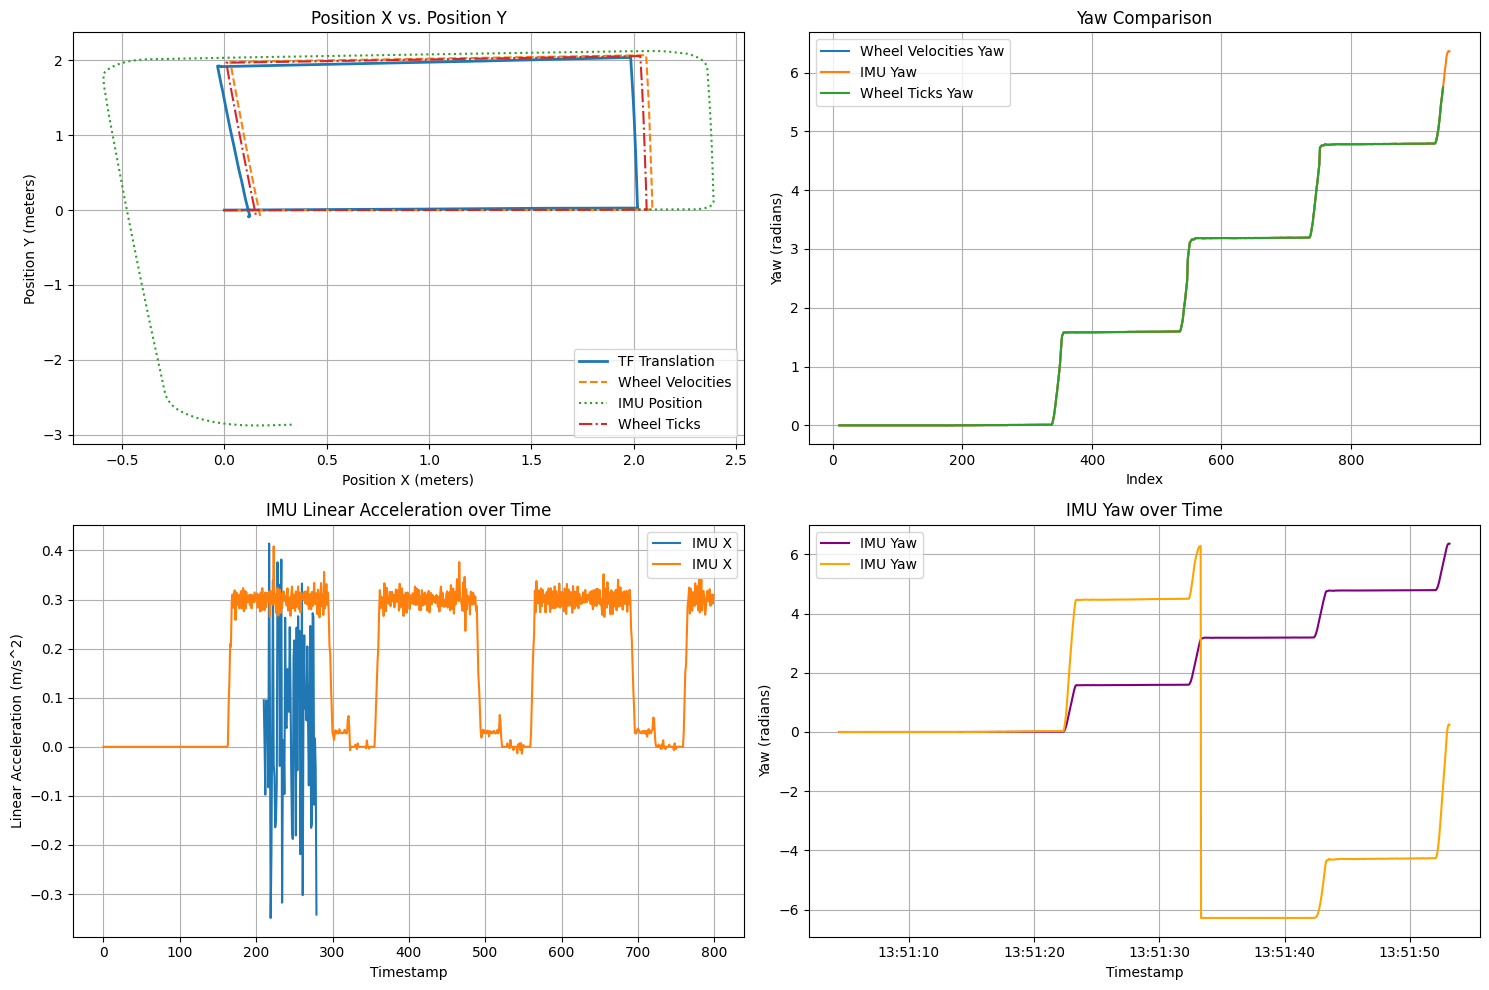

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

# Constants
WHEEL_RADIUS = 0.072 / 2  # Radius of the wheel (meters)
WHEEL_BASE = 0.235        # Distance between wheels (meters)
TICKS_PER_REVOLUTION = 508.8
DATA_LIMIT = 953          # Set to -1 for no limit on data

# Load data
def load_data(filename, limit=DATA_LIMIT):
    """Loads a CSV file and applies a data limit if specified."""
    df = pd.read_csv(f'{filename}')
    output_df = df[:limit] if limit > 0 else df[:]
    output_df = add_timestamps(output_df, 'timestamp_sec', 'timestamp_nanosec')
    return output_df[10:]
# Preprocessing Functions
def add_timestamps(df, sec_col, nsec_col):
    """Add a combined timestamp column and delta_time to the dataframe."""
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df[sec_col], unit='s') + pd.to_timedelta(df[nsec_col], unit='ns')
    df['delta_time'] = df['timestamp'].diff().dt.total_seconds()
    df.loc[0, 'delta_time'] = 0
    return df

def calculate_wheel_velocities(df):
    """Calculate linear and angular velocities from wheel data."""
    df['linear_velocity'] = (df['velocity_left'] + df['velocity_right']) * WHEEL_RADIUS / 2
    df.loc[0, 'linear_velocity'] = 0
    df['angular_velocity'] = (df['velocity_right'] - df['velocity_left']) * WHEEL_RADIUS / WHEEL_BASE
    df.loc[0, 'angular_velocity'] = 0
    df['delta_yaw'] = df['angular_velocity'] * df['delta_time']

    if 'yaw' not in df.columns:
        df['yaw'] = df['delta_yaw'].cumsum()
    
    df['speed_x'] = df['linear_velocity'] * np.cos(df['yaw'])
    df['speed_y'] = df['linear_velocity'] * np.sin(df['yaw'])
    df['displacement_x'] = df['speed_x'] * df['delta_time']
    df['displacement_y'] = df['speed_y'] * df['delta_time']
    df['position_x'] = df['displacement_x'].cumsum()
    df['position_y'] = df['displacement_y'].cumsum()
    return df

def calculate_wheel_ticks(df):
    """Calculate velocities and positions using wheel tick data."""
    print(TICKS_PER_REVOLUTION)
    df['delta_ticks_left'] = df['ticks_left'].diff()
    df.loc[0, 'delta_ticks_left'] = 0
    df['delta_ticks_right'] = df['ticks_right'].diff()
    df.loc[0, 'delta_ticks_right'] = 0
    df['angular_velocity_left'] = (2 * np.pi * df['delta_ticks_left']) / (TICKS_PER_REVOLUTION * df['delta_time'])
    df.loc[0, 'angular_velocity_left'] = 0
    df['angular_velocity_right'] = (2 * np.pi * df['delta_ticks_right']) / (TICKS_PER_REVOLUTION * df['delta_time'])
    df.loc[0, 'angular_velocity_right'] = 0
    df['velocity_left'] = df['angular_velocity_left']
    df['velocity_right'] = df['angular_velocity_right']
    return calculate_wheel_velocities(df)

def calculate_imu_position(df):
    """Calculate positions from IMU data."""
    # Calculate yaw from quaternion (as before)
    w = df['orientation_w']
    x = df['orientation_x']
    y = df['orientation_y']
    z = df['orientation_z']
    
    df['yaw_wrapped'] = np.arctan2(2.0 * (w * z + x * y), 1.0 - 2.0 * (y * y + z * z))
    df['yaw'] = np.unwrap(df['yaw_wrapped'])

    df['acceleration_x'] = df['linear_acceleration_x'] * np.cos(df['yaw'])
    df['acceleration_y'] = df['linear_acceleration_y'] * np.sin(df['yaw'])

    # Reconstruct the yaw
    df['velocity_x'] = (df['linear_acceleration_x'] * df['delta_time']).cumsum()
    df['velocity_y'] = (df['linear_acceleration_y'] * df['delta_time']).cumsum()

    # Calculate total velocity magnitude
    df['linear_velocity'] = np.sqrt(df['velocity_x']**2 + df['velocity_y']**2)
    
    df['speed_x'] = df['linear_velocity'] * np.cos(df['yaw']) #df['speed_imu_x']
    df['speed_y'] = df['linear_velocity'] * np.sin(df['yaw'])#df['speed_imu_y']
    df['displacement_x'] = df['speed_x'] * df['delta_time']
    df['displacement_y'] = df['speed_y'] * df['delta_time']
    df['position_x'] = df['displacement_x'].cumsum()
    df['position_y'] = df['displacement_y'].cumsum()

    return df

def calculate_mouse_position(mouse_df, imu_df):
    """Calculate mouse-based positions, rotated using IMU yaw."""

    mouse_df['delta_x'] = mouse_df['integrated_x'].diff() *-1
    mouse_df['delta_y'] = mouse_df['integrated_y'].diff() 
    mouse_df['rotated_delta_x'] = mouse_df['delta_x'] * np.cos(imu_df['yaw'])
    mouse_df['rotated_delta_y'] = mouse_df['delta_y'] * np.sin(imu_df['yaw'])
    mouse_df['position_x'] = mouse_df['rotated_delta_x'].cumsum()
    mouse_df['position_y'] = mouse_df['rotated_delta_y'].cumsum()
    return mouse_df

def align_timestamps(df1, df2, df3, df4):
    """Align five dataframes based on timestamps using pd.merge_asof."""
    # Assuming df1 has the most complete/accurate timestamps, use it as the base
    base_timestamps = df1['timestamp']

    # Align each DataFrame to the base timestamps
    df2 = pd.merge_asof(df2, base_timestamps, on='timestamp', direction='nearest')
    df3 = pd.merge_asof(df3, base_timestamps, on='timestamp', direction='nearest')
    df4 = pd.merge_asof(df4, base_timestamps, on='timestamp', direction='nearest')

    return df1, df2, df3, df4

def quaternion_cords(df):
    w = df['rotation_w']
    x = df['rotation_x']
    y = df['rotation_y']
    z = df['rotation_z']
    
    df['yaw_wrapped'] = np.arctan2(2.0 * (w * z + x * y), 1.0 - 2.0 * (y * y + z * z))
    df['yaw'] = np.unwrap(df['yaw_wrapped'])

    return df

# Load DataFrames
tf_df = load_data('tf_data.csv')
imu_df = load_data('imu_data.csv')
mouse_df = load_data('mouse_data.csv')
wheel_ticks_df = load_data('wheel_ticks_data.csv')
wheel_vels_df = load_data('wheel_vels_data.csv')

tf_df = quaternion_cords(tf_df)

# Align DataFrames
imu_df, mouse_df, wheel_ticks_df, wheel_vels_df = align_timestamps(imu_df, mouse_df, wheel_ticks_df, wheel_vels_df)
print(len(imu_df), len(mouse_df), len(wheel_ticks_df), len(wheel_vels_df))
# Process Data
imu_df = calculate_imu_position(imu_df)
mouse_df = calculate_mouse_position(mouse_df, imu_df)
wheel_ticks_df['yaw'] = imu_df['yaw'] + 0.00029
wheel_ticks_df = calculate_wheel_ticks(wheel_ticks_df)
wheel_vels_df['yaw'] = imu_df['yaw']
wheel_vels_df = calculate_wheel_velocities(wheel_vels_df)

# Plot Results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Subplot 1: Position X vs. Position Y
axs[0, 0].plot(tf_df['translation_x'], tf_df['translation_y'], label='TF Translation', linewidth=2)
axs[0, 0].plot(wheel_vels_df['position_x'], wheel_vels_df['position_y'], label='Wheel Velocities', linestyle='--')
axs[0, 0].plot(imu_df['position_x'], imu_df['position_y'], label='IMU Position', linestyle=':')
axs[0, 0].plot(wheel_ticks_df['position_x'], wheel_ticks_df['position_y'], label='Wheel Ticks', linestyle='-.')
# axs[0, 0].plot(mouse_df['position_x'], mouse_df['position_y'], label='Mouse Translation', linewidth=1)
axs[0, 0].set_xlabel('Position X (meters)')
axs[0, 0].set_ylabel('Position Y (meters)')
axs[0, 0].set_title('Position X vs. Position Y')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Subplot 2: Difference in Timestamps between IMU and Wheel Ticks Data
timestamp_diff = imu_df['timestamp'].values - wheel_vels_df['timestamp'].values
axs[0, 1].plot(wheel_vels_df['yaw'], label='Wheel Velocities Yaw')
axs[0, 1].plot(imu_df['yaw'], label='IMU Yaw')
axs[0, 1].plot(wheel_ticks_df['yaw'], label='Wheel Ticks Yaw')
axs[0, 1].set_xlabel('Index')
axs[0, 1].set_ylabel('Yaw (radians)')
axs[0, 1].set_title('Yaw Comparison')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Subplot 3: IMU Linear Acceleration X over Time
data_df = imu_df[:170]
print("Variance of angular_velocity_z:", data_df['angular_velocity_z'].var())
print("Variance of linear_acceleration_x:", data_df['linear_acceleration_x'].var())
print("Variance of linear_acceleration_y:", data_df['linear_acceleration_y'].var())
print("Variance of orientation_z:", data_df['orientation_z'].var())
data_df = imu_df[200:270]
print("Variance of angular_velocity_z:", data_df['angular_velocity_z'].var())
print("Variance of linear_acceleration_x:", data_df['linear_acceleration_x'].var())
print("Variance of linear_acceleration_y:", data_df['linear_acceleration_y'].var())
print("Variance of orientation_z:", data_df['orientation_z'].var())
axs[1, 0].plot( data_df['linear_acceleration_x'], label='IMU X')
axs[1, 0].plot( wheel_ticks_df['linear_velocity'][:800], label='IMU X')
# axs[1, 0].plot(imu_df['timestamp'], imu_df['velocity_y'], label='IMU Y')
# axs[1, 0].set_xlabel('Timestamp')
axs[1, 0].set_xlabel('Timestamp')
axs[1, 0].set_ylabel('Linear Acceleration (m/s^2)')
axs[1, 0].set_title('IMU Linear Acceleration over Time')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Subplot 4: IMU Yaw over Time
axs[1, 1].plot(imu_df['timestamp'], imu_df['yaw'], label='IMU Yaw', color='purple')
axs[1, 1].plot(imu_df['timestamp'], np.deg2rad(imu_df['orientation_z'] * 360), label='IMU Yaw', color='orange')
axs[1, 1].set_xlabel('Timestamp')
axs[1, 1].set_ylabel('Yaw (radians)')
axs[1, 1].set_title('IMU Yaw over Time')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


0.017115897328236623


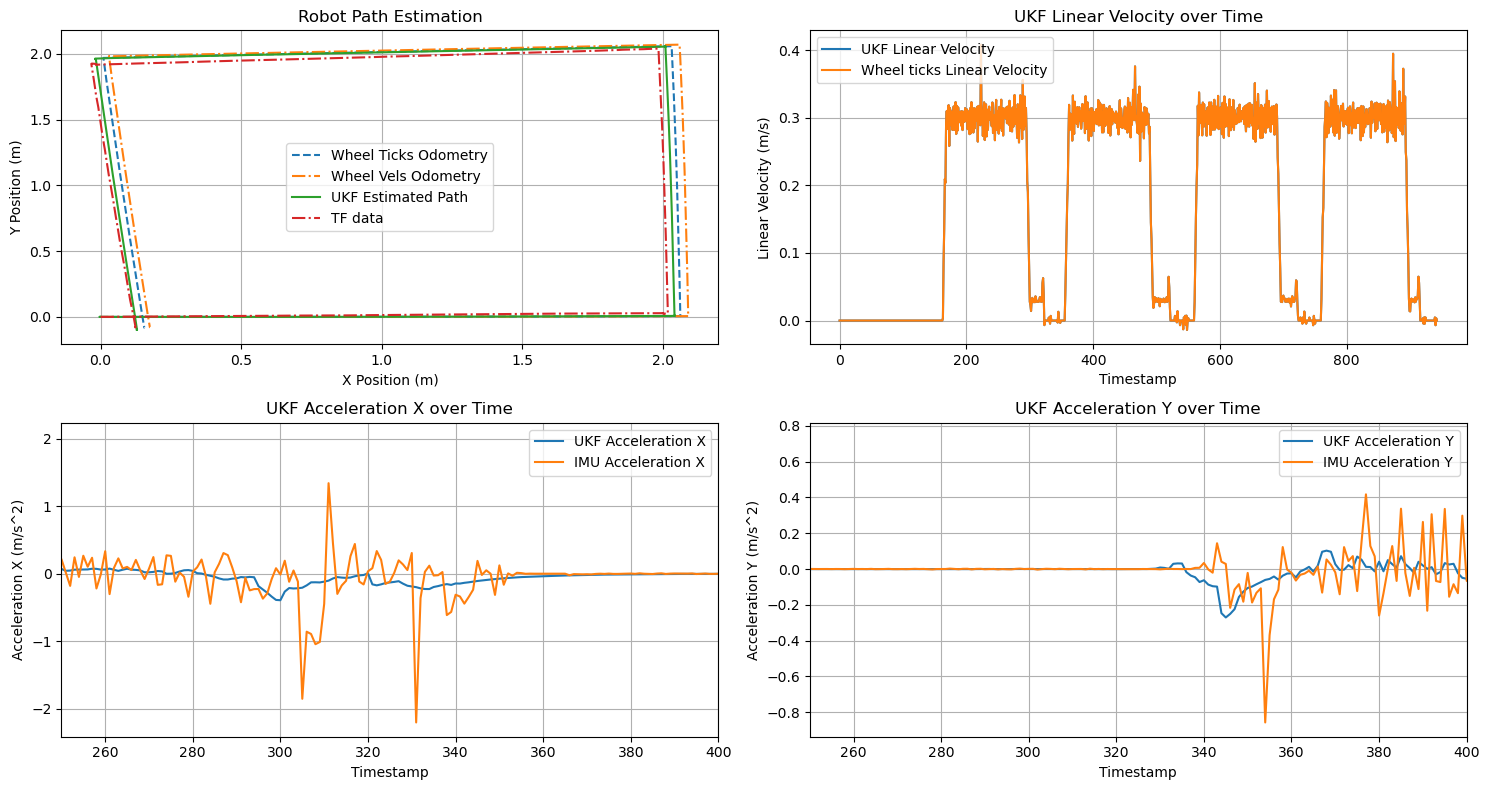

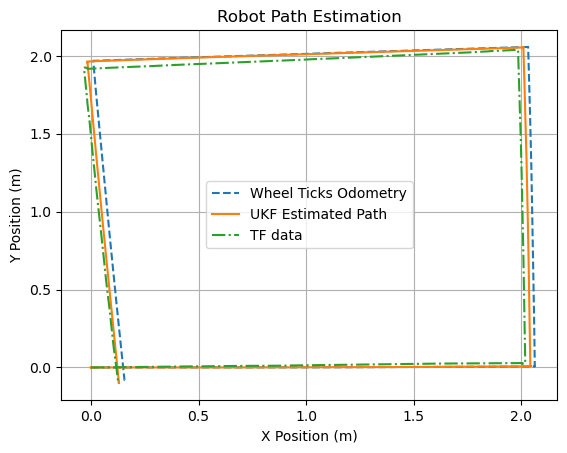

In [2]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

def f_x(state, dt):
    """
    State transition function for the robot.

    States:
        x[0]: x position
        x[1]: y position
        x[2]: yaw
        x[3]: linear velocity
        x[4]: x acceleration
        x[5]: y acceleration
        x[6]: yaw rate 
    """
    x, y, yaw, v, a_x, a_y, yaw_rate = state

    new_x = x + v * np.cos(yaw) * dt + 0.5 * a_x * dt**2
    new_y = y + v * np.sin(yaw) * dt + 0.5 * a_y * dt**2
    new_yaw = yaw + yaw_rate * dt
    # Calculate the unit vector in the direction of the current velocity (using yaw)
    v_unit_x = np.cos(yaw)
    v_unit_y = np.sin(yaw)

    # Project the acceleration onto the velocity unit vector
    a_parallel = a_x * v_unit_x + a_y * v_unit_y

    # Update the velocity
    new_v = v + a_parallel * dt
    # new_v = v + np.sqrt(a_x**2 + a_y**2) * dt
    return np.array([new_x, new_y, new_yaw, new_v, a_x, a_y, yaw_rate])

# 2. Measurement Function
def h_x(state):
    """
    Measurement function. We measure the linear velocity, yaw, acceleration_x, acceleration_y and yaw rate

    States:
        x[0]: x position
        x[1]: y position
        x[2]: yaw
        x[3]: linear velocity
        x[4]: x acceleration
        x[5]: y acceleration
        x[6]: yaw rate
    """
    return np.array([state[3], state[2], state[4], state[5], state[6]])  # [linear velocity, yaw, acceleration_x, acceleration_y, yaw_rate]

# 3. Sigma Points and Weights
points = MerweScaledSigmaPoints(n=7, alpha=0.1, beta=2.0, kappa=-1)

# 4. Create UKF
ukf = UKF(dim_x=7, dim_z=5, fx=f_x, hx=h_x, dt=imu_df['delta_time'].iloc[0], points=points)

# 5. Initialize State
# (x, y, yaw, v, a_x, a_y, yaw_rate)
ukf.x = np.array([0., 0., imu_df['yaw'].iloc[0], wheel_vels_df['linear_velocity'].iloc[0], imu_df['acceleration_x'].iloc[0], imu_df['acceleration_y'].iloc[0], imu_df['angular_velocity_z'].iloc[0]])  
# x, y, yaw, v, a_x, a_y, yaw_rate
ukf.P = np.diag([
    0.001 ** 2,  # x position variance (increase if you have no prior knowledge of initial position)
    0.001 ** 2,  # y position variance (increase if you have no prior knowledge of initial position)
    np.deg2rad(5)**2,  # Yaw variance (e.g., standard deviation of 5 degrees)
    0.01**2,  # Linear velocity variance
    data_df['linear_acceleration_x'][:170].var(),  # a_x variance (from stationary data)
    data_df['linear_acceleration_y'][:170].var(),  # a_y variance (from stationary data)
    0.001**2   # Yaw rate variance
])

# 6. Measurement Noise
ukf.R = np.diag([
    0.004 ** 2,  #  linear velocity variance from encoders (placeholder - needs to be determined)
    imu_df['orientation_z'][:170].var(),  # Increased yaw variance (stationary)
    imu_df['linear_acceleration_x'][:170].var(),    # a_x variance (stationary)
    imu_df['linear_acceleration_y'][:170].var(),    # a_y variance (stationary)
    imu_df['angular_velocity_z'][:170].var()  # Increased yaw rate variance (stationary)
])

print(imu_df['linear_acceleration_x'][:170].var())

# 7. Process Noise
ukf.Q = np.diag([
    0.05 ** 2,  # x position process noise variance
    0.05 ** 2,  # y position process noise variance
    np.deg2rad(1) ** 2,  # Yaw process noise variance 
    0.5 ** 2,  # linear velocity process noise variance
    (1 * 1e-2) ** 2,   # a_x process noise variance
    (1* 1e-2) ** 2 ,   # a_y process noise variance
    1e-2 ** 2   # Yaw rate process noise variance
])

# 8. Run the Filter
z_combined = np.zeros((len(imu_df), 5))
z_combined[:, 0] = wheel_ticks_df['linear_velocity'].values  # Use linear velocity from wheel velocities
z_combined[:, 1] = imu_df['yaw'].values
z_combined[:, 2] = imu_df['acceleration_x'].values
z_combined[:, 3] = imu_df['acceleration_y'].values
z_combined[:, 4] = imu_df['angular_velocity_z'].values

# Prepare 'dts' to be used in batch_filter
dts = imu_df['delta_time'].values

# Run the filter with the combined measurements
mu, cov = ukf.batch_filter(z_combined, dts=dts)

# 9. Extract Results
ukf_x, ukf_y, ukf_yaw, ukf_v, ukf_a_x, ukf_a_y, ukf_yaw_rate = mu[:, 0], mu[:, 1], mu[:, 2], mu[:, 3], mu[:, 4], mu[:, 5], mu[:, 6]

# 10. Plot Results
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

# Subplot 1: Robot Path Estimation
axs[0, 0].plot(wheel_ticks_df['position_x'], wheel_ticks_df['position_y'], label='Wheel Ticks Odometry', linestyle='--')
axs[0, 0].plot(wheel_vels_df['position_x'], wheel_vels_df['position_y'], label='Wheel Vels Odometry', linestyle='-.')
axs[0, 0].plot(ukf_x, ukf_y, label='UKF Estimated Path', linestyle='-')
axs[0, 0].plot(tf_df['translation_x'], tf_df['translation_y'], label='TF data', linestyle='-.')
axs[0, 0].set_xlabel('X Position (m)')
axs[0, 0].set_ylabel('Y Position (m)')
axs[0, 0].set_title('Robot Path Estimation')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Subplot 2: UKF Linear Velocity
axs[0,1].plot(ukf_v, label='UKF Linear Velocity', linestyle='-')
axs[0,1].plot(wheel_ticks_df['linear_velocity'], label='Wheel ticks Linear Velocity', linestyle='-')
axs[0,1].set_xlabel('Timestamp')
axs[0,1].set_ylabel('Linear Velocity (m/s)')
axs[0,1].set_title('UKF Linear Velocity over Time')
axs[0,1].legend()
axs[0,1].grid(True)

# Subplot 3: UKF Acceleration X
axs[1, 0].plot(ukf_a_x, label='UKF Acceleration X', linestyle='-')
axs[1, 0].plot(imu_df['acceleration_x'], label='IMU Acceleration X', linestyle='-')
# axs[1, 0].set_ylim(-0.1, 0.100)
axs[1, 0].set_xlim(250, 400)
axs[1, 0].set_xlabel('Timestamp')
axs[1, 0].set_ylabel('Acceleration X (m/s^2)')
axs[1, 0].set_title('UKF Acceleration X over Time')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Subplot 3: UKF Acceleration Y
axs[1, 1].plot(ukf_a_y, label='UKF Acceleration Y', linestyle='-')
axs[1, 1].plot(imu_df['acceleration_y'], label='IMU Acceleration Y', linestyle='-')
axs[1, 1].set_xlim(250, 400)
axs[1, 1].set_xlabel('Timestamp')
axs[1, 1].set_ylabel('Acceleration Y (m/s^2)')
axs[1, 1].set_title('UKF Acceleration Y over Time')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.plot(wheel_ticks_df['position_x'], wheel_ticks_df['position_y'], label='Wheel Ticks Odometry', linestyle='--')
# plt.plot(wheel_vels_df['position_x'], wheel_vels_df['position_y'], label='Wheel Vels Odometry', linestyle='-.')
plt.plot(ukf_x, ukf_y, label='UKF Estimated Path', linestyle='-')
plt.plot(tf_df['translation_x'], tf_df['translation_y'], label='TF data', linestyle='-.')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Robot Path Estimation')
plt.legend()
plt.grid(True)

plt.show()

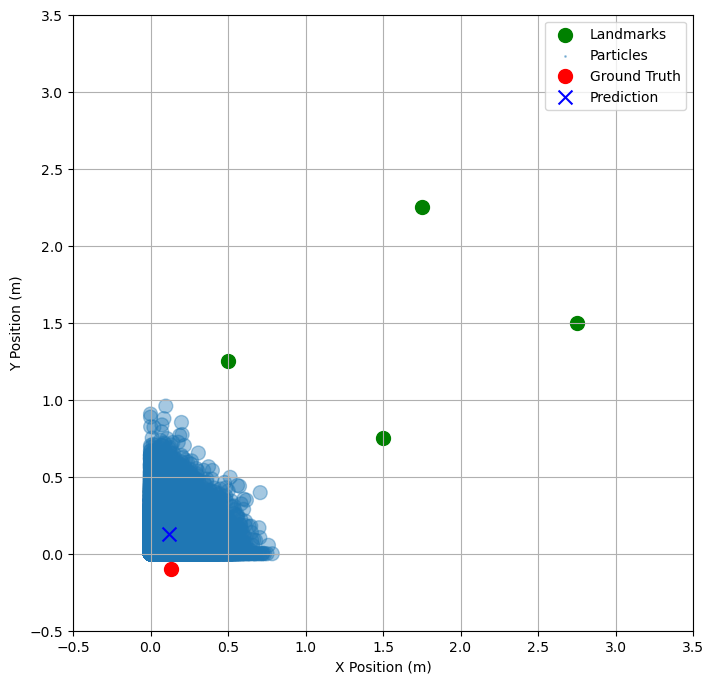

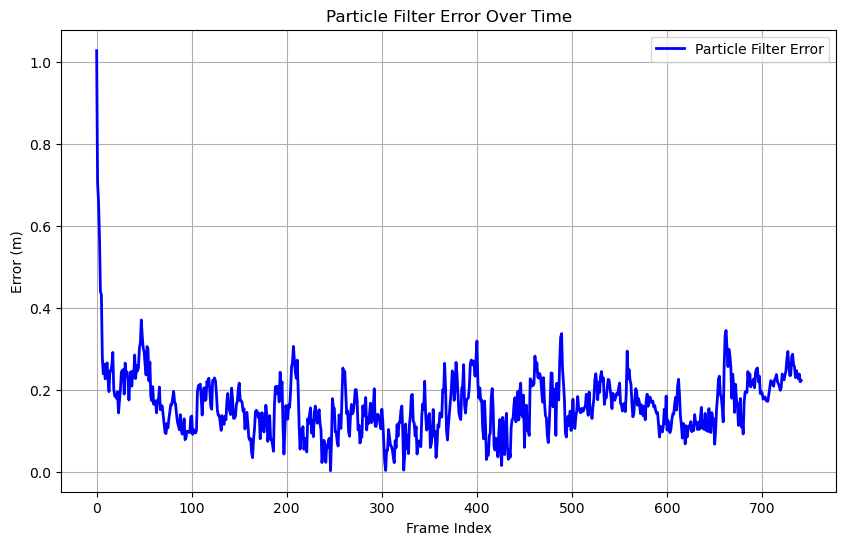

Mean Particle Filter Error: 0.1642 meters
Max Particle Filter Error: 1.0284 meters
GIF saved as 'adaptive_particle_filter_uniform.gif'


In [14]:
import scipy.stats
import matplotlib.animation as animation

# Constants
DELTA_T = 0.01  # Time step (seconds)
AREA_LIMIT = 3.0  # 3x3 square
NUM_PARTICLES = 15000  # Initial number of particles
MOTION_NOISE = [0.1, 0.1, np.deg2rad(1)]  # Noise in [x, y, theta]
LANDMARKS = [[1.5, 0.75], [2.75, 1.5], [1.75, 2.25], [0.5, 1.25]]  # Landmarks in the area
START_FRAME = 200  # Start frame for the animation
END_FRAME = 1000  # End frame for the animation

# Particle Filter Class
class ParticleFilter:
    def __init__(self, num_particles, area_limit):
        self.num_particles = num_particles
        self.area_limit = area_limit
        self.particles = self.create_uniform_particles((0, area_limit), (0, area_limit), (-np.pi, np.pi), num_particles)
        self.weights = np.ones(num_particles) / num_particles

    def create_uniform_particles(self, x_range, y_range, hdg_range, N):
        """Initialize particles uniformly."""
        particles = np.empty((N, 3))
        particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=N)
        particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
        particles[:, 2] = np.random.uniform(hdg_range[0], hdg_range[1], size=N)
        particles[:, 2] %= 2 * np.pi
        return particles

    def predict(self, control_input):
        """Propagate particles using the motion model with noise."""
        v, yaw = control_input  # Linear and angular velocity
        noise = np.random.normal(0, MOTION_NOISE, (self.num_particles, 3))
        self.particles[:, 2] += yaw + noise[:, 2]  # Update theta
        self.particles[:, 0] += (v * np.cos(self.particles[:, 2]) * DELTA_T + noise[:, 0])  # Update x
        self.particles[:, 1] += (v * np.sin(self.particles[:, 2]) * DELTA_T + noise[:, 1])  # Update y
        self.particles[:, 0] = np.clip(self.particles[:, 0], 0, self.area_limit)  # Clamp x
        self.particles[:, 1] = np.clip(self.particles[:, 1], 0, self.area_limit)  # Clamp y

    def update(self, measurements, measurement_noise, landmarks):
        """Update particle weights based on measurements to landmarks."""
        for i, landmark in enumerate(landmarks):
            distances = np.linalg.norm(self.particles[:, :2] - landmark, axis=1)
            self.weights *= scipy.stats.norm(distances, measurement_noise[0]).pdf(measurements[i])
        self.weights += 1.e-300  # Avoid division by zero
        self.weights /= np.sum(self.weights)  # Normalize weights

    def neff(self):
        """Compute the effective number of particles."""
        return 1. / np.sum(np.square(self.weights))

    def resample(self):
        """Perform resampling using systematic resampling."""
        N = len(self.weights)
        positions = (np.random.rand() + np.arange(N)) / N
        indexes = np.zeros(N, 'i')
        cumulative_sum = np.cumsum(self.weights)
        i, j = 0, 0
        while i < N:
            if positions[i] < cumulative_sum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1
        self.particles = self.particles[indexes]
        self.weights.fill(1.0 / N)

    def estimate(self):
        """Estimate the state as the weighted mean of the particles."""
        mean = np.average(self.particles, weights=self.weights, axis=0)
        var = np.average((self.particles - mean)**2, weights=self.weights, axis=0)
        return mean, var

# Simulate Landmark Measurements
def simulate_landmark_measurements(ground_truth, landmarks, noise_std):
    """Simulate measurements from the ground truth position to landmarks."""
    measurements = []
    for landmark in landmarks:
        distance = np.sqrt((ground_truth[0] - landmark[0])**2 + (ground_truth[1] - landmark[1])**2)
        noisy_distance = distance + np.random.normal(0, noise_std)
        measurements.append(noisy_distance)
    return measurements


# Initialize Particle Filter
pf = ParticleFilter(NUM_PARTICLES, AREA_LIMIT)

# Load tf_data
tf_x, tf_y, tf_yaw, tf_v = ukf_x[START_FRAME:END_FRAME], ukf_y[START_FRAME:END_FRAME], ukf_yaw[START_FRAME:END_FRAME], ukf_v[START_FRAME:END_FRAME]   
ground_truth = np.vstack((tf_x, tf_y, tf_yaw)).T

# Initialize Particle Filter
fig, ax = plt.subplots(figsize=(8, 8))
landmark_scatter = ax.scatter([l[0] for l in LANDMARKS], [l[1] for l in LANDMARKS],
                               color='green', label='Landmarks', s=100)
particles_scatter = ax.scatter([], [], s=[], alpha=0.4, label='Particles')
ground_truth_scatter = ax.scatter([], [], color='red', label='Ground Truth', s=100)
predicted_scatter = ax.scatter([], [], color='blue', marker='x', label='Prediction', s=100)
ax.set_xlim(-0.5, AREA_LIMIT + 0.5)
ax.set_ylim(-0.5, AREA_LIMIT + 0.5)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.legend()
ax.grid()

# List to store errors over time
errors = []

# Animation update function
def update(frame):
    # For the first frame, just show the initial particle distribution
    if frame == 0:
        particles_scatter.set_offsets(pf.particles[:, :2])
        particles_scatter.set_sizes(np.full(pf.num_particles, 100))
        return particles_scatter, 

    # For subsequent frames, proceed with the particle filter steps
    control_input = [tf_v[frame], tf_yaw[frame]] 
    measurement = simulate_landmark_measurements(ground_truth[frame], LANDMARKS, noise_std=0.4)

    pf.predict(control_input)
    pf.update(measurement, measurement_noise=[0.8], landmarks=LANDMARKS)
    pf.resample()

    estimated_mean, _ = pf.estimate()

    # Calculate error (Euclidean distance) between ground truth and prediction
    ground_truth_position = ground_truth[frame, :2]
    particle_filter_position = estimated_mean[:2]
    error = np.linalg.norm(ground_truth_position - particle_filter_position)
    errors.append(error)  # Store error for this frame

    particles_scatter.set_offsets(pf.particles[:, :2])
    particles_scatter.set_sizes(np.full(pf.num_particles, 100))
    ground_truth_scatter.set_offsets([ground_truth[frame, 0], ground_truth[frame, 1]])
    predicted_scatter.set_offsets([estimated_mean[0], estimated_mean[1]])

    return particles_scatter, ground_truth_scatter, predicted_scatter

ani = animation.FuncAnimation(fig, update, frames=len(ground_truth), interval=200, blit=False)

# Save as GIF
ani.save('adaptive_particle_filter_uniform.gif', writer='pillow', fps=5)

# Plot Error Over Time After Animation
plt.figure(figsize=(10, 6))
plt.plot(range(len(errors)), errors, label='Particle Filter Error', color='blue', linewidth=2)
plt.xlabel('Frame Index')
plt.ylabel('Error (m)')
plt.title('Particle Filter Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Print Mean and Max Error
mean_error = np.mean(errors)
max_error = np.max(errors)
print(f"Mean Particle Filter Error: {mean_error:.4f} meters")
print(f"Max Particle Filter Error: {max_error:.4f} meters")

print("GIF saved as 'adaptive_particle_filter_uniform.gif'")


# APPENDIX

943 943 943 943
508.8


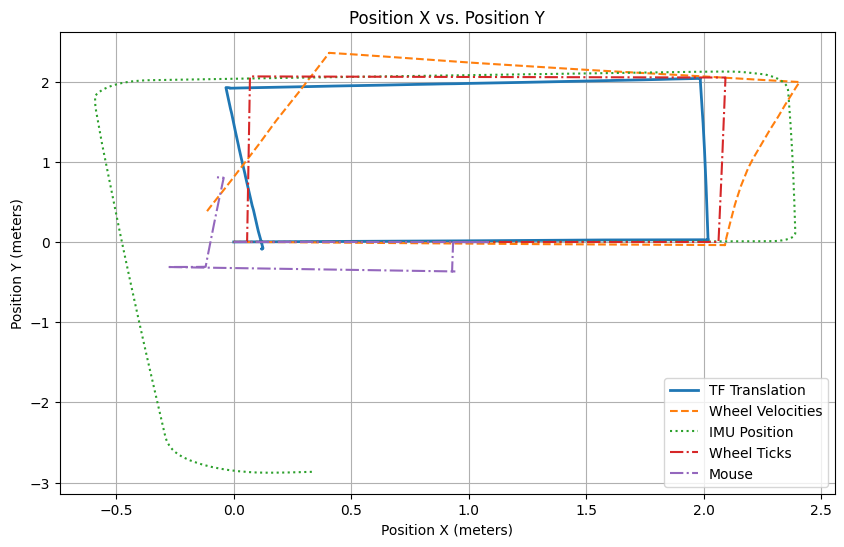

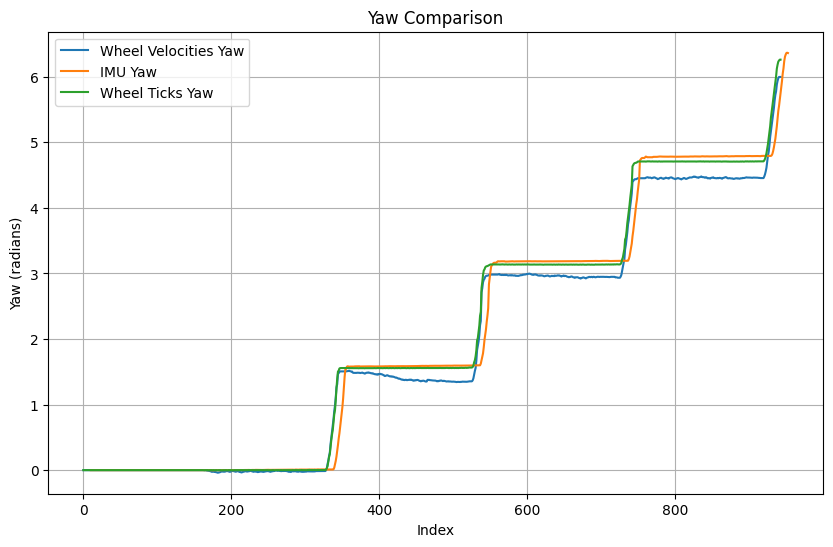

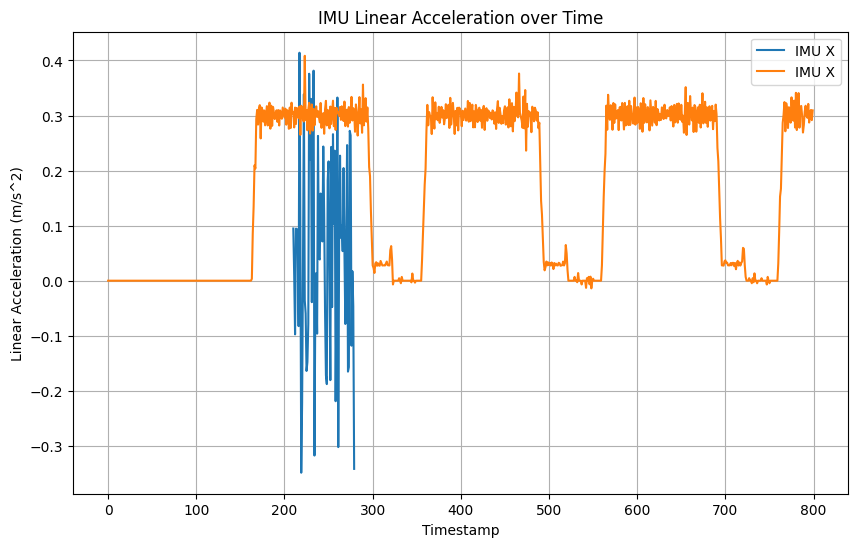

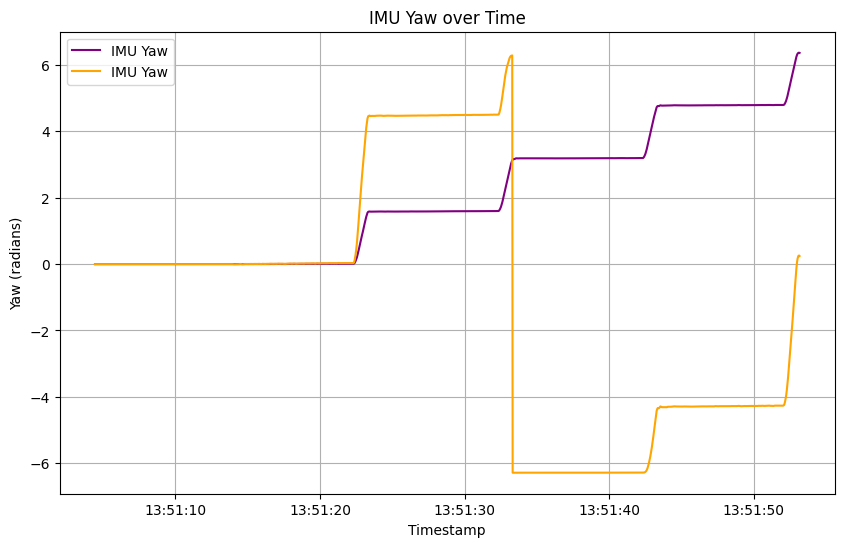

In [2]:
# Load DataFrames
tf_df = load_data('tf_data.csv')
imu_df = load_data('imu_data.csv')
mouse_df = load_data('mouse_data.csv')
wheel_ticks_df = load_data('wheel_ticks_data.csv')
wheel_vels_df = load_data('wheel_vels_data.csv')

tf_df = quaternion_cords(tf_df)

# Align DataFrames
imu_df, mouse_df, wheel_ticks_df, wheel_vels_df = align_timestamps(imu_df, mouse_df, wheel_ticks_df, wheel_vels_df)
print(len(imu_df), len(mouse_df), len(wheel_ticks_df), len(wheel_vels_df))
# Process Data
imu_df = calculate_imu_position(imu_df)
mouse_df = calculate_mouse_position(mouse_df, imu_df)
# wheel_ticks_df['yaw'] = imu_df['yaw'] + 0.00029
wheel_ticks_df = calculate_wheel_ticks(wheel_ticks_df)
# wheel_vels_df['yaw'] = imu_df['yaw']
wheel_vels_df = calculate_wheel_velocities(wheel_vels_df)

# Plot Results
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(tf_df['translation_x'], tf_df['translation_y'], label='TF Translation', linewidth=2)
plt.plot(wheel_vels_df['position_x'], wheel_vels_df['position_y'], label='Wheel Velocities', linestyle='--')
plt.plot(imu_df['position_x'], imu_df['position_y'], label='IMU Position', linestyle=':')
plt.plot(wheel_ticks_df['position_x'], wheel_ticks_df['position_y'], label='Wheel Ticks', linestyle='-.')
plt.plot(mouse_df['position_x'], mouse_df['position_y'], label='Mouse', linestyle='-.')
plt.xlabel('Position X (meters)')
plt.ylabel('Position Y (meters)')
plt.title('Position X vs. Position Y')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
timestamp_diff = imu_df['timestamp'].values - wheel_vels_df['timestamp'].values
plt.plot(wheel_vels_df['yaw'], label='Wheel Velocities Yaw')
plt.plot(imu_df['yaw'], label='IMU Yaw')
plt.plot(wheel_ticks_df['yaw'], label='Wheel Ticks Yaw')
plt.xlabel('Index')
plt.ylabel('Yaw (radians)')
plt.title('Yaw Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data_df['linear_acceleration_x'], label='IMU X')
plt.plot(wheel_ticks_df['linear_velocity'][:800], label='IMU X')
plt.xlabel('Timestamp')
plt.ylabel('Linear Acceleration (m/s^2)')
plt.title('IMU Linear Acceleration over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(imu_df['timestamp'], imu_df['yaw'], label='IMU Yaw', color='purple')
plt.plot(imu_df['timestamp'], np.deg2rad(imu_df['orientation_z'] * 360), label='IMU Yaw', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Yaw (radians)')
plt.title('IMU Yaw over Time')
plt.legend()
plt.grid(True)
plt.show()

943 943 943 943
508.8


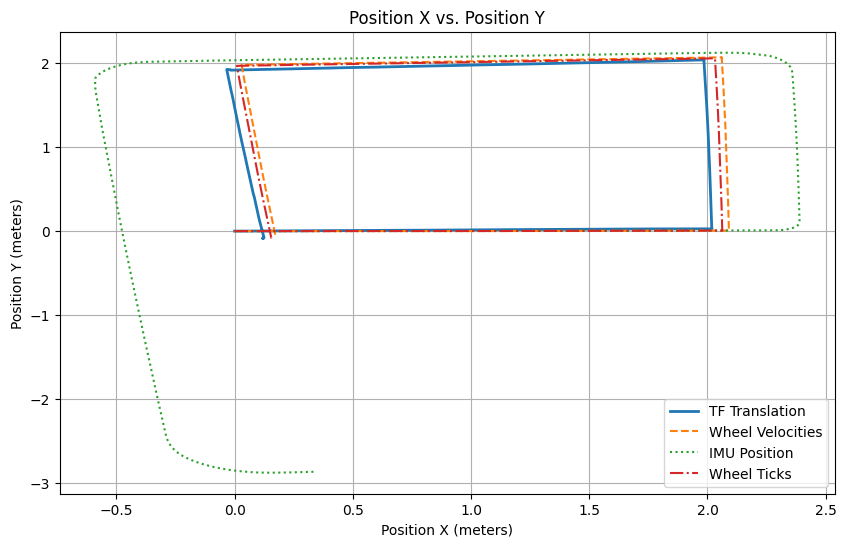

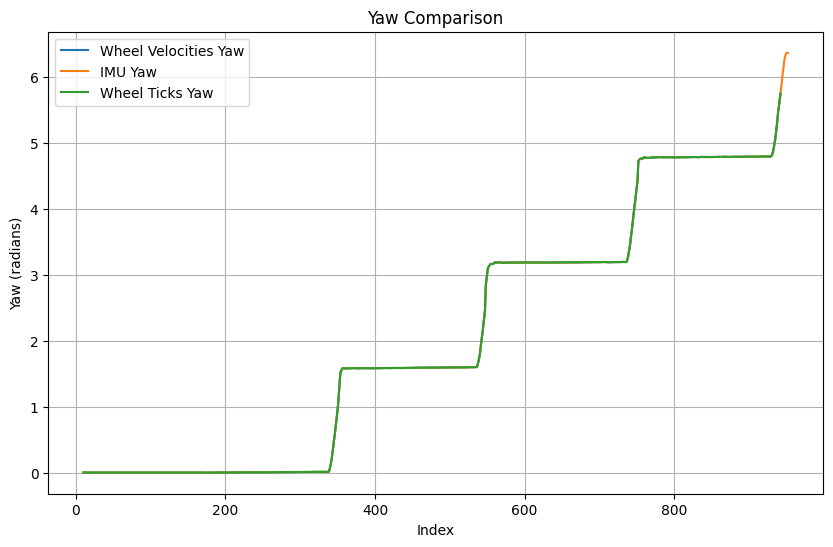

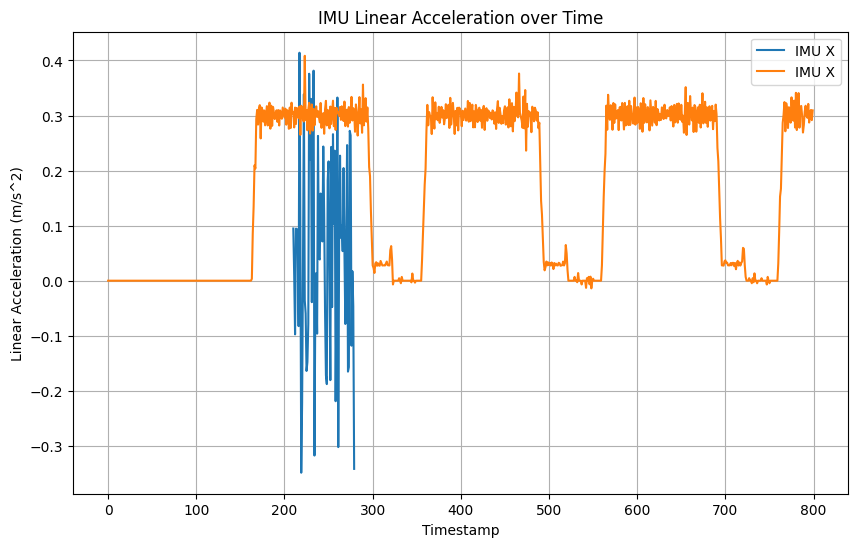

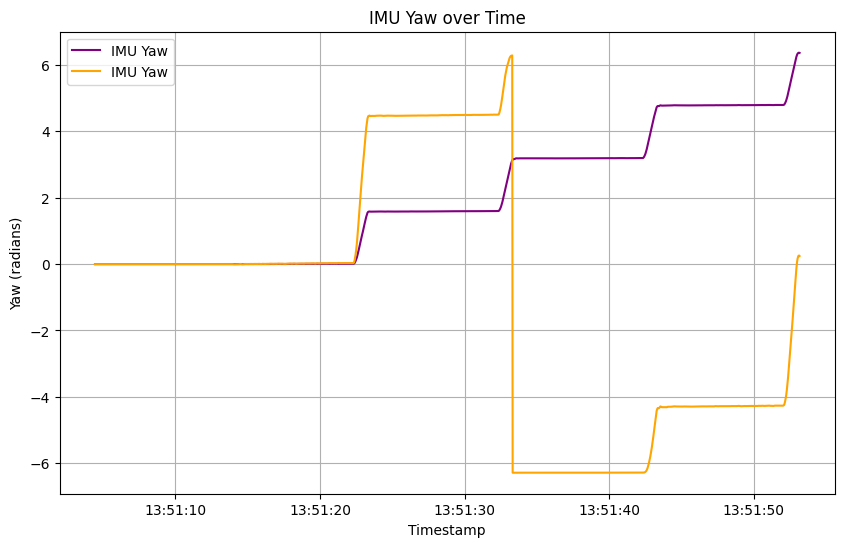

In [3]:
tf_df = load_data('tf_data.csv')
imu_df = load_data('imu_data.csv')
mouse_df = load_data('mouse_data.csv')
wheel_ticks_df = load_data('wheel_ticks_data.csv')
wheel_vels_df = load_data('wheel_vels_data.csv')

tf_df = quaternion_cords(tf_df)

# Align DataFrames
imu_df, mouse_df, wheel_ticks_df, wheel_vels_df = align_timestamps(imu_df, mouse_df, wheel_ticks_df, wheel_vels_df)
print(len(imu_df), len(mouse_df), len(wheel_ticks_df), len(wheel_vels_df))
# Process Data
imu_df = calculate_imu_position(imu_df)
mouse_df = calculate_mouse_position(mouse_df, imu_df)
wheel_ticks_df['yaw'] = imu_df['yaw'] + 0.00029
wheel_ticks_df = calculate_wheel_ticks(wheel_ticks_df)
wheel_vels_df['yaw'] = imu_df['yaw']
wheel_vels_df = calculate_wheel_velocities(wheel_vels_df)

# Plot Results
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(tf_df['translation_x'], tf_df['translation_y'], label='TF Translation', linewidth=2)
plt.plot(wheel_vels_df['position_x'], wheel_vels_df['position_y'], label='Wheel Velocities', linestyle='--')
plt.plot(imu_df['position_x'], imu_df['position_y'], label='IMU Position', linestyle=':')
plt.plot(wheel_ticks_df['position_x'], wheel_ticks_df['position_y'], label='Wheel Ticks', linestyle='-.')
# plt.plot(mouse_df['position_x'], mouse_df['position_y'], label='Mouse', linestyle='-.')
plt.xlabel('Position X (meters)')
plt.ylabel('Position Y (meters)')
plt.title('Position X vs. Position Y')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
timestamp_diff = imu_df['timestamp'].values - wheel_vels_df['timestamp'].values
plt.plot(wheel_vels_df['yaw'], label='Wheel Velocities Yaw')
plt.plot(imu_df['yaw'], label='IMU Yaw')
plt.plot(wheel_ticks_df['yaw'], label='Wheel Ticks Yaw')
plt.xlabel('Index')
plt.ylabel('Yaw (radians)')
plt.title('Yaw Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data_df['linear_acceleration_x'], label='IMU X')
plt.plot(wheel_ticks_df['linear_velocity'][:800], label='IMU X')
plt.xlabel('Timestamp')
plt.ylabel('Linear Acceleration (m/s^2)')
plt.title('IMU Linear Acceleration over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(imu_df['timestamp'], imu_df['yaw'], label='IMU Yaw', color='purple')
plt.plot(imu_df['timestamp'], np.deg2rad(imu_df['orientation_z'] * 360), label='IMU Yaw', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Yaw (radians)')
plt.title('IMU Yaw over Time')
plt.legend()
plt.grid(True)
plt.show()